In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

pd.set_option('display.max_rows', 10000)
pd.set_option('display.max_columns', 1000)

#load data
fraud_data = pd.read_csv('Fraud_Data.csv')
ip_data = pd.read_csv('IpAddress_to_Country.csv')
#load combined data
data = pd.read_csv('fraud_ip_data.csv')

data.head(2)

/Users/renjia/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,lower_bound_ip_address,upper_bound_ip_address,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,729808896.0,734003199.0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,335544320.0,352321535.0,United States


0.09364577267192546

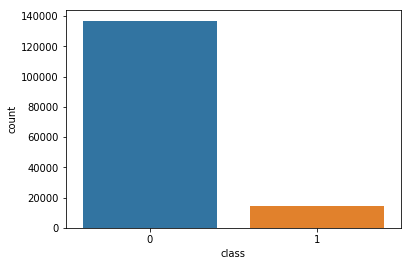

In [125]:
sns.countplot(x='class', data=data_all_cat)

print 'Overall fraudulent activity rate:', 1.0*data_all_cat[data_all_cat['class']==1].shape[0]/data_all_cat.shape[0] 

In [3]:
data.nunique()/data.shape[0]
#purchase_time, device_id and ip_address not unique.

user_id                   1.000000
signup_time               1.000000
purchase_time             0.997135
purchase_value            0.000807
device_id                 0.912939
source                    0.000020
browser                   0.000033
sex                       0.000013
age                       0.000384
ip_address                0.949706
class                     0.000013
lower_bound_ip_address    0.170761
upper_bound_ip_address    0.170761
country                   0.001198
dtype: float64

In [2]:
#Feature extraction from raw dataset
class FeatureExtraction(object):
    '''Feature engineering: features extraction from raw dataset.'''
    def __init__(self):
        pass

    def feature_device_id_unique_users(self, data):
        ''' 'device_id_unique_users': how many unique users use the same device_id?'''
        deviceIdUsers = data.groupby('device_id')['user_id'].nunique()
        deviceIdUsers = pd.DataFrame(deviceIdUsers).rename(columns={'device_id': 'device_id', 'user_id': 'device_id_unique_users'})
        data = pd.merge(data, deviceIdUsers, how='left', on='device_id')
        return data

    def feature_total_avg_purchase(self, data):
        '''create features total_purchase and avg_purchase.'''
        totalPurchase = data.groupby('device_id')['purchase_value'].agg({'total_purchase': 'sum'})
        totalPurchase = pd.DataFrame(totalPurchase)
        data = pd.merge(data, totalPurchase, how='left', on='device_id')
        data['avg_purchase'] = data['total_purchase'] / data['device_id_unique_users']
        return data

    def feature_country_count(self, data):
        '''create features country_count: how many counts from the same country.'''
        countryCount = data.groupby('country')['user_id'].agg({'country_count': 'size'})
        countryCount = pd.DataFrame(countryCount)
        data = pd.merge(data, countryCount, how='left', on='country')
        return data

    def feature_time_diff(self, data):
        '''create feature time_diff: time difference between purchase and signup times.'''
        data['purchase_time'] = pd.to_datetime(data['purchase_time'])
        data['signup_time'] = pd.to_datetime(data['signup_time'])
        data['time_diff'] = data['purchase_time'] - data['signup_time']
        data['time_diff'] = data['time_diff'] / np.timedelta64(1, 's')
        return data

    def feature_ip_users(self, data):
        '''create feature 'ip_users': how many users use the same ip address.'''
        ipUsers = data.groupby('ip_address')['user_id'].nunique()
        ipUsers = pd.DataFrame(ipUsers).rename(columns={'user_id': 'ip_users'})
        data = pd.merge(data, ipUsers, how='left', on='ip_address')
        return data
    def feature_purchase_times(self, data):
        '''create feature 'purchase_times': how many users make the transactions at the exactly same time.'''
        purchaseTime = data.groupby('purchase_time')['user_id'].nunique()
        purchaseTime = pd.DataFrame(purchaseTime).rename(columns={'user_id': 'purchase_times'})
        data = pd.merge(data, purchaseTime, how='left', on='purchase_time')
        return data

    def feature_DOTW_WOTY(self, data):
        '''create features 'day_of_the_week, DOTW' and 'week_of_the_year, WOTY' from both signup and purchase dates.'''
        data['DOTW_signup'] = pd.to_datetime(data['signup_time']).dt.day_name()
        data['DOTW_purchase'] = pd.to_datetime(data['purchase_time']).dt.day_name()
        data['WOTY_signup'] = pd.to_datetime(data['signup_time']).dt.weekofyear
        data['WOTY_purchase'] = pd.to_datetime(data['purchase_time']).dt.weekofyear
        return data
        
    def transform(self, data):
        data = self.feature_device_id_unique_users(data)
        data = self.feature_total_avg_purchase(data)
        data = self.feature_country_count(data)
        data = self.feature_time_diff(data)
        data = self.feature_ip_users(data)
        data = self.feature_purchase_times(data)
        data = self.feature_DOTW_WOTY(data)
        return data
        
data = FeatureExtraction().transform(data)

In [3]:
class Preprocess(object):
    def __init__(self):
        pass

    def feature_drop(self, data):
        colsDropped = ['signup_time', 'purchase_time', 'lower_bound_ip_address', 'upper_bound_ip_address']
        data = data.drop(colsDropped, axis=1)
        return data

    def imputer(self, data):
        '''imputer the missing values:  country: 21966; country_count: 21966.'''
        data.loc[data['country'].isnull(), 'country'] = 'unknown'
        data.loc[data['country'] == 'unknown', 'country_count'] = 21966  # data_all.loc[data_all.country=='unknown', :].count()
        data.loc[data['country_count'].isnull(), 'country_count'] = 0
        return data

    def bin_country(self, data):
        data.loc[data['country_count'] < 200, 'country'] = 'Small'  # 50 countries with counts > 200.
        return data

    def reduce_skewness(self, data):
        '''Log transform to reduce data skewness of numeric features.'''
        numericFeatures = data.select_dtypes(include='number').columns.tolist()
        numericFeatures.remove('class')
        skewness = data[numericFeatures].apply(lambda x: skew(x.dropna())).sort_values()
        skewFeatures = skewness[abs(skewness) > 0.5].index
        for feature in skewFeatures:
            data[feature] = np.log1p(data[feature])
        return data

    def log_transform(self, data):
        '''Non-skewed numeric features, for logistic regression.'''
        features = ['age', 'time_diff', 'country_count']

        for feature in features:
            data[feature] = np.log1p(data[feature])

        return data

    def convert_dtypes(self, data):
        data['WOTY_purchase'] = data['WOTY_purchase'].astype(str)
        return data

    def feature_encoding(self, data):
        le = preprocessing.LabelEncoder().fit(data['device_id'])
        data['device_id'] = le.transform(data['device_id'])
        return data

    def categorical_feature_encoding(self, data):
        data = pd.get_dummies(data)
        return data

    def preprocess(self, data):
        data = self.feature_drop(data)
        data = self.imputer(data)
        data = self.bin_country(data)
        data = self.reduce_skewness(data)
#         data = self.log_transform(data)
        data = self.convert_dtypes(data)
#         data = self.feature_encoding(data)
#         data = self.categorical_feature_encoding(data)
        return data

data = Preprocess().preprocess(data)

In [5]:
cols = data.columns.tolist()
cols = cols[0:1]+cols[2:3]+cols[7:8]+cols[3:6]+cols[9:10]+cols[1:2]+cols[6:7]+cols[10:]+cols[8:9]
data = data[cols]
data.head(1)

,user_id,device_id,ip_address,source,browser,sex,country,purchase_value,age,device_id_unique_users,total_purchase,avg_purchase,country_count,time_diff,ip_users,purchase_times,DOTW_signup,DOTW_purchase,WOTY_signup,WOTY_purchase,class
0,22058,QVPSPJUOCKZAR,7.327584e+08,SEO,Chrome,M,Japan,3.555348,39,0.693147,3.555348,3.555348,7306.0,4506682.0,0.693147,0.693147,Tuesday,Saturday,9,16,0


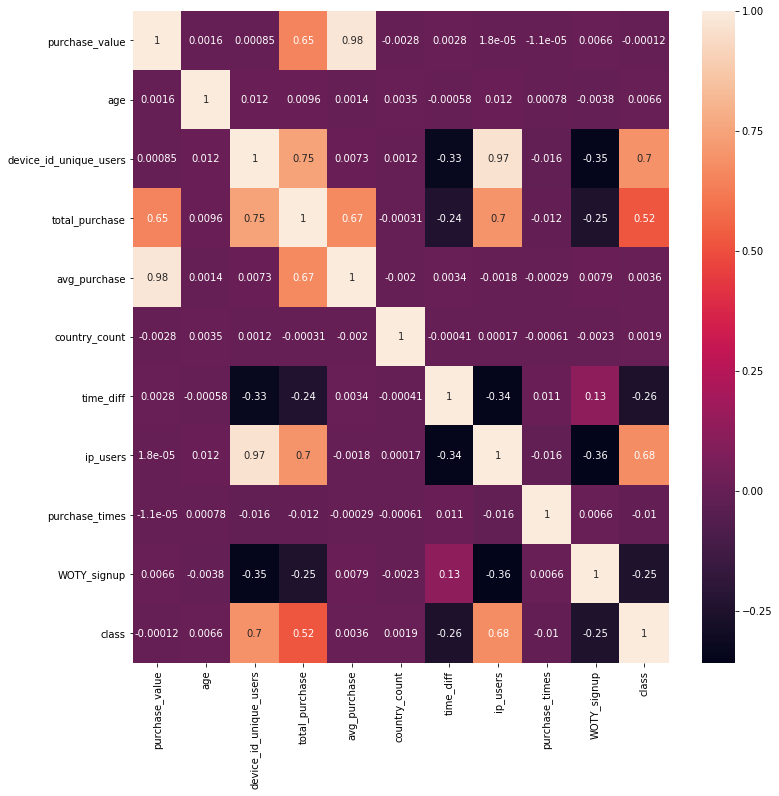

In [6]:
plt.figure(figsize=(12,12))
sns.heatmap(data.iloc[:, 7:].corr(), annot=True)

In [7]:
data.describe()

,user_id,ip_address,purchase_value,age,device_id_unique_users,total_purchase,avg_purchase,country_count,time_diff,ip_users,purchase_times,WOTY_signup,class
count,151112.000000,1.511120e+05,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000,151112.000000,151112.000000,151112.000000
mean,200171.040970,2.152145e+09,3.510192,33.140704,0.825281,3.698875,3.514838,27498.834838,4.932029e+06,0.794543,0.695480,16.501740,0.093646
std,115369.285024,1.248497e+09,0.520442,8.617733,0.432038,0.772547,0.510821,24994.221984,3.126263e+06,0.423229,0.030859,9.814287,0.291336
min,2.000000,5.209350e+04,2.302585,18.000000,0.693147,2.302585,2.302585,1.000000,1.000000e+00,0.693147,0.693147,1.000000,0.000000
25%,100642.500000,1.085934e+09,3.135494,27.000000,0.693147,3.218876,3.178054,3161.000000,2.186754e+06,0.693147,0.693147,8.000000,0.000000
50%,199958.000000,2.154770e+09,3.583519,33.000000,0.693147,3.663562,3.583519,21966.000000,4.926346e+06,0.693147,0.693147,16.000000,0.000000
75%,300054.000000,3.243258e+09,3.912023,39.000000,0.693147,4.043051,3.891820,58049.000000,7.644524e+06,0.693147,0.693147,25.000000,0.000000
max,400000.000000,4.294850e+09,5.043425,76.000000,3.044522,7.285507,5.043425,58049.000000,1.036797e+07,3.044522,1.386294,34.000000,1.000000


Fraud from flash transactions (1s) : 0.050293821801


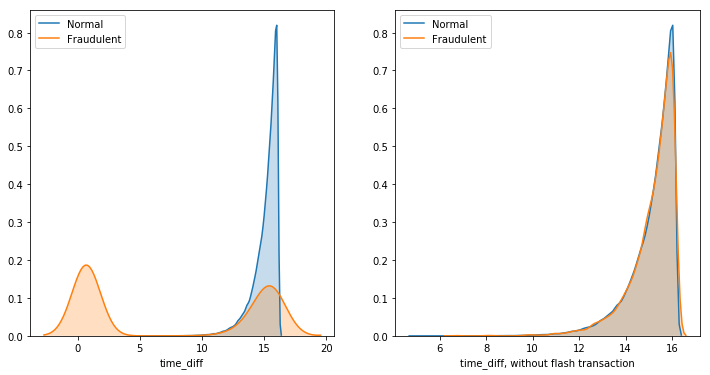

In [22]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
sns.kdeplot(np.log1p(data.loc[data['class']==0, 'time_diff']), label='Normal', shade=True,ax=ax[0])
sns.kdeplot(np.log1p(data.loc[data['class']==1, 'time_diff']), label='Fraudulent', shade=True,ax=ax[0])
ax[0].set_xlabel('time_diff')

sns.kdeplot(np.log1p(data.loc[(data['class']==0)&(data['time_diff']!=1), 'time_diff']), label='Normal', shade=True,ax=ax[1])
sns.kdeplot(np.log1p(data.loc[(data['class']==1)&(data['time_diff']!=1), 'time_diff']), label='Fraudulent', shade=True,ax=ax[1])
ax[1].set_xlabel('time_diff, without flash transaction')

print 'Fraud from flash transactions (1s) :', 1.0*data[(data['class']==1)&(data['time_diff']==1)].shape[0]/data.shape[0]
#There is no normal transaction occurred at just 1 second. Thus, all 1s transactions will be classified as fraud.
#There is no time_diff difference between normal and fraudulent once removed flash transaction (1s).

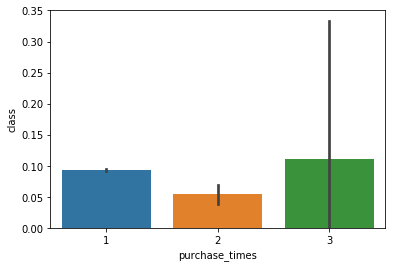

In [14]:
sns.barplot(x='purchase_times', y='class', data=data)

Text(0.5,0,u'age, without flash transaction')

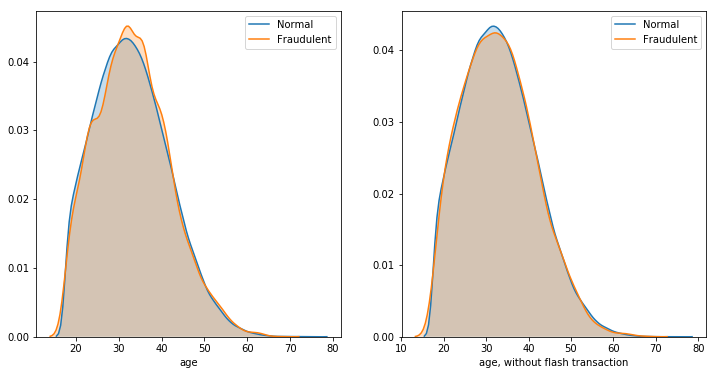

In [23]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
sns.kdeplot(data.loc[data['class']==0, 'age'], label='Normal', shade=True, ax=ax[0])
sns.kdeplot(data.loc[data['class']==1, 'age'], label='Fraudulent', shade=True, ax=ax[0])
ax[0].set_xlabel('age')

sns.kdeplot(data.loc[(data['class']==0)&(data['time_diff']!=1), 'age'], label='Normal', shade=True, ax=ax[1])
sns.kdeplot(data.loc[(data['class']==1)&(data['time_diff']!=1), 'age'], label='Fraudulent', shade=True, ax=ax[1])
ax[1].set_xlabel('age, without flash transaction')


Text(0.5,0,u'country_count, without flash transaction')

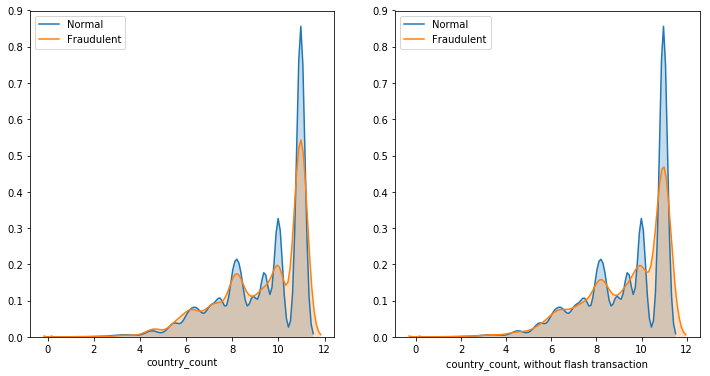

In [24]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
sns.kdeplot(np.log1p(data.loc[data['class']==0, 'country_count']), label='Normal', shade=True, ax=ax[0])
sns.kdeplot(np.log1p(data.loc[data['class']==1, 'country_count']), label='Fraudulent', shade=True, ax=ax[0])
ax[0].set_xlabel('country_count')


sns.kdeplot(np.log1p(data.loc[(data['class']==0)&(data['time_diff']!=1), 'country_count']), label='Normal', shade=True, ax=ax[1])
sns.kdeplot(np.log1p(data.loc[(data['class']==1)&(data['time_diff']!=1), 'country_count']), label='Fraudulent', shade=True, ax=ax[1])
ax[1].set_xlabel('country_count, without flash transaction')


unique device_id_unique users: 0.872075017206


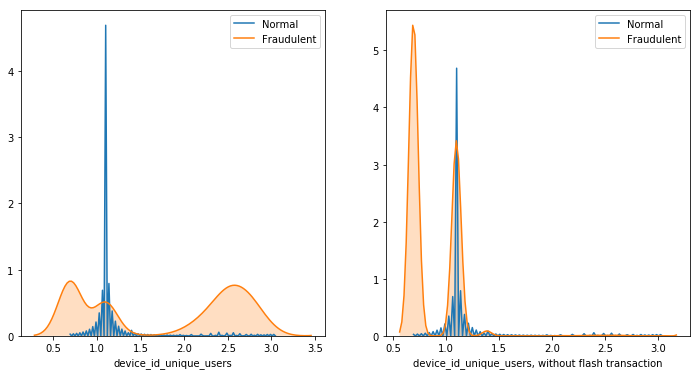

In [27]:
fig, ax = plt.subplots(1,2,figsize=(12,6))

sns.kdeplot(data.loc[data['class']==0, 'device_id_unique_users'], label='Normal', shade=True, ax=ax[0])
sns.kdeplot(data.loc[data['class']==1, 'device_id_unique_users'], label='Fraudulent', shade=True, ax=ax[0])
ax[0].set_xlabel('device_id_unique_users')

sns.kdeplot(data.loc[(data['class']==0)&(data['time_diff']!=1), 'device_id_unique_users'], label='Normal', shade=True, ax=ax[1])
sns.kdeplot(data.loc[(data['class']==1)&(data['time_diff']!=1), 'device_id_unique_users'], label='Fraudulent', shade=True, ax=ax[1])
ax[1].set_xlabel('device_id_unique_users, without flash transaction')

print 'unique device_id_unique users:', 1.0*data[data['device_id_unique_users']==np.log1p(1)].shape[0]/data.shape[0]

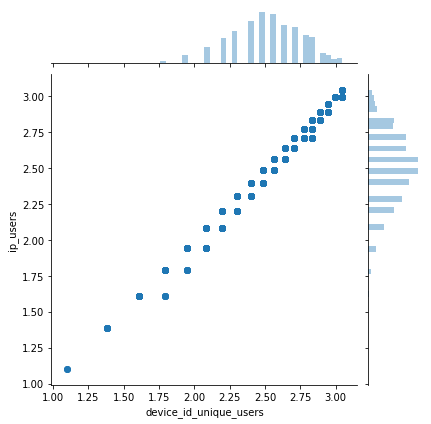

In [25]:
sns.jointplot(x='device_id_unique_users', y='ip_users', data=data[(data['ip_users']>1)])

Text(0.5,0,u'avg_purchase')

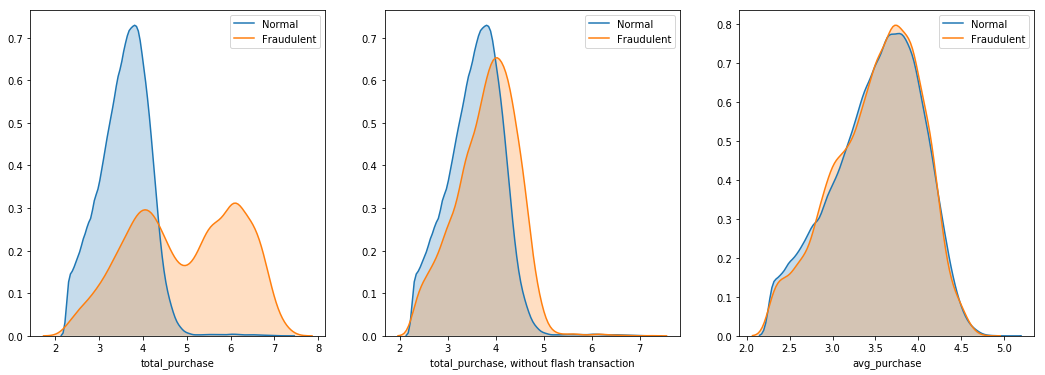

In [30]:
fig, ax = plt.subplots(1,3,figsize=(18,6))

sns.kdeplot((data.loc[data['class']==0, 'total_purchase']), label='Normal', shade=True, ax=ax[0])
sns.kdeplot((data.loc[data['class']==1, 'total_purchase']), label='Fraudulent', shade=True, ax=ax[0])
ax[0].set_xlabel('total_purchase')

sns.kdeplot((data.loc[(data['class']==0)&(data['time_diff']!=1), 'total_purchase']), label='Normal', shade=True, ax=ax[1])
sns.kdeplot((data.loc[(data['class']==1)&(data['time_diff']!=1), 'total_purchase']), label='Fraudulent', shade=True, ax=ax[1])
ax[1].set_xlabel('total_purchase, without flash transaction')

sns.kdeplot((data.loc[data['class']==0, 'avg_purchase']), label='Normal', shade=True, ax=ax[2])
sns.kdeplot((data.loc[data['class']==1, 'avg_purchase']), label='Fraudulent', shade=True, ax=ax[2])
ax[2].set_xlabel('avg_purchase')

#Fraud tends to have higher total purchase values by making more frequent transactions.

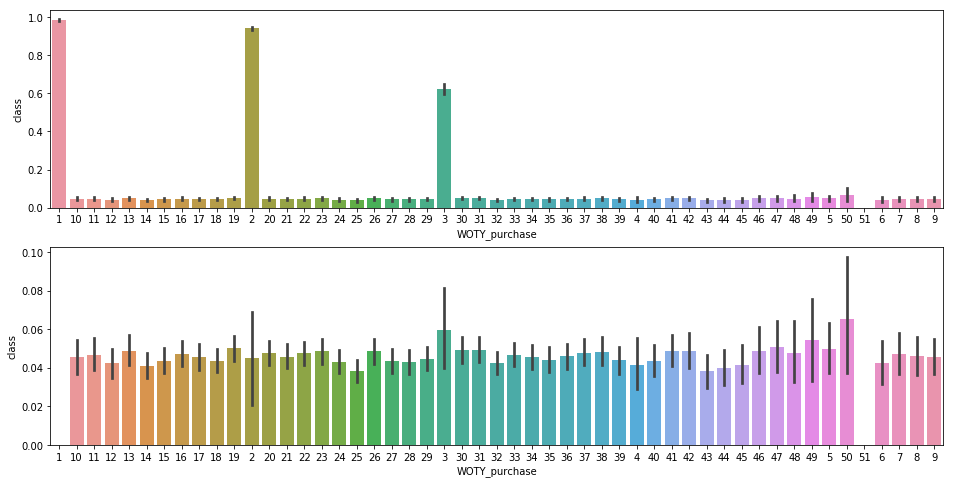

In [35]:
fig, ax = plt.subplots(2,1,figsize=(16,8))
sns.barplot(x='WOTY_purchase', y='class', data=data, ax=ax[0])
sns.barplot(x='WOTY_purchase', y='class', data=data[data['time_diff']!=1], ax=ax[1])

#Wa! Flash transactions mostly occur at the first three weeks of the year!!!

Text(0.5,0,u'browser, without flash transaction')

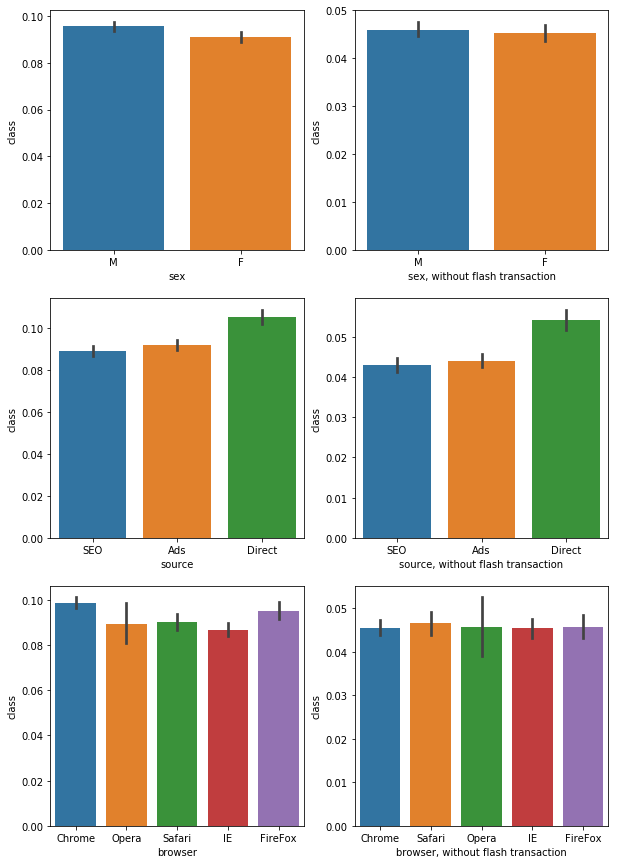

In [32]:
fig, ax = plt.subplots(3,2,figsize=(10,15))
sns.barplot(x='sex', y='class', data=data, ax=ax[0][0])
sns.barplot(x='sex', y='class', data=data[data['time_diff']!=1], ax=ax[0][1])
ax[0][1].set_xlabel('sex, without flash transaction')
sns.barplot(x='source', y='class', data=data, ax=ax[1][0])
sns.barplot(x='source', y='class', data=data[data['time_diff']!=1], ax=ax[1][1])
ax[1][1].set_xlabel('source, without flash transaction')
sns.barplot(x='browser', y='class', data=data, ax=ax[2][0])
sns.barplot(x='browser', y='class', data=data[data['time_diff']!=1], ax=ax[2][1])
ax[2][1].set_xlabel('browser, without flash transaction')

#no preference in sex, source and browser for frauds regardless flash transaction or all.

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

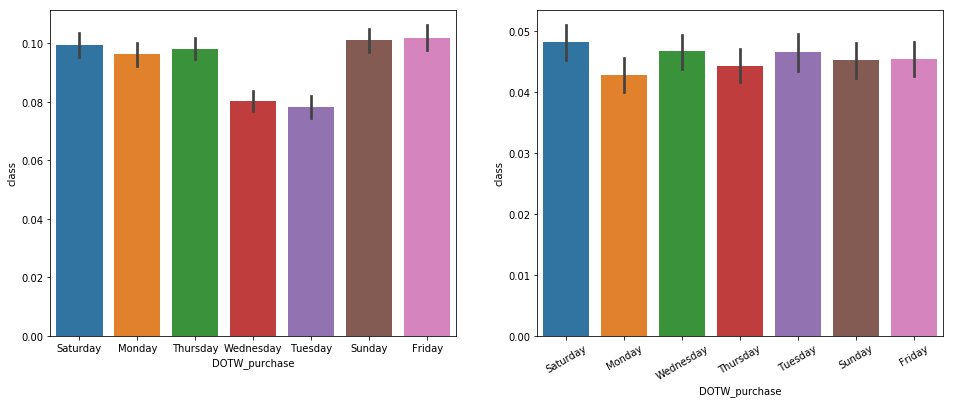

In [34]:
fig, ax = plt.subplots(1,2,figsize=(16,6))
sns.barplot(x='DOTW_purchase', y='class', data=data, ax=ax[0])
sns.barplot(x='DOTW_purchase', y='class', data=data[data['time_diff']!=1], ax=ax[1])

#No preference in days either.

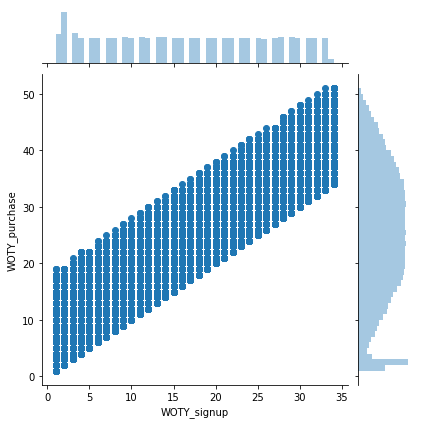

In [158]:
sns.jointplot(x='WOTY_signup', y='WOTY_purchase', data=data_all_cat)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]),
 <a list of 51 Text xticklabel objects>)

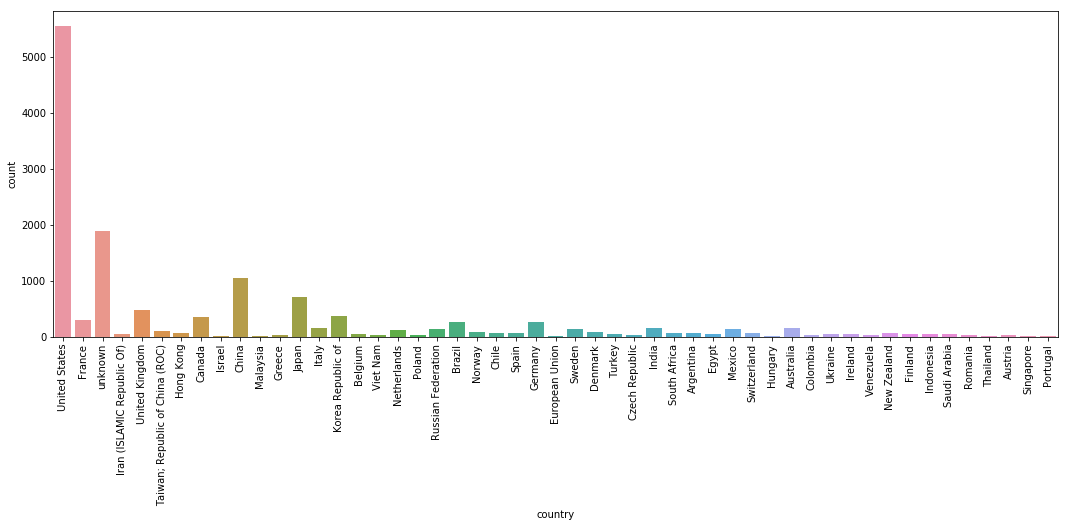

In [52]:
plt.figure(figsize=(18,6))
sns.countplot(x='country', data=data[(data.country_count>200)&(data['class']==1)])
plt.xticks(rotation=90)

#Large populated countries have more fraud counts, but again it could be due to their large population.
#In fact, it is small countries like Ireland, New Zealand, etc. has higher fraud rate (from train data).

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]),
 <a list of 51 Text xticklabel objects>)

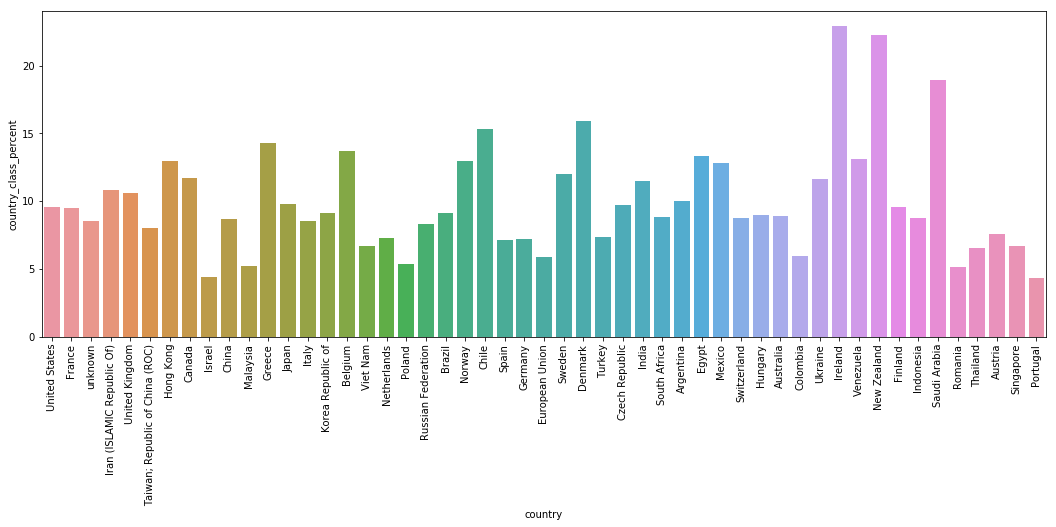

In [51]:
cc = data.groupby(['country', 'class'])['user_id'].agg({'country_class': 'size'})
data = data.merge(cc, how='left', on=['country', 'class'])
data['country_class_percent'] = 100*(data['country_class']/data['country_count'])

plt.figure(figsize=(18,6))
sns.barplot(x='country', y='country_class_percent', data=data[(data.country_count>200)&(data['class']==1)])
plt.xticks(rotation=90)

#'country_class_percent' is only for understanding, not for modeling, or it will lead significant overfitting since test is unknown.